In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [231]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [232]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [233]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [234]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [235]:
data = data[data['FIPS'] != 'not county']

In [236]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [237]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [238]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [239]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str})

In [240]:
population.columns = ['FIPS', 'urban_influence', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [241]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [242]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])

In [243]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [244]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,0.033898
5,01007,1.0,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [245]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [246]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,-0.033898
5,01007,1.0,22533,-0.016670,0.102094


In [247]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [248]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
unemployment = unemployment.set_index('FIPS')
unemployment2 = pd.read_excel('data/CLF01.xls', sheetname='Sheet9', usecols=['STCOU', 'CLF040210D'], converters={'STCOU': str})
unemployment2.columns = ['FIPS', 'unemployment_2009']
unemployment = unemployment.join(unemployment2.set_index('FIPS'))
unemployment['unemp_change'] = unemployment['unemployment_2009'] - unemployment['unemployment']
data = data.join(unemployment.drop('unemployment_2009', axis=1))

In [249]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
poverty = poverty.set_index('FIPS')
poverty2 = pd.read_excel('data/IPE01.xls', sheetname='Sheet5', usecols=['STCOU', 'IPE120209D'], converters={'STCOU': str})
poverty2.columns = ['FIPS', 'poverty_2009']
poverty = poverty.join(poverty2.set_index('FIPS'))
poverty['pov_change'] = poverty['poverty_2009'] - poverty['poverty']
data = data.join(poverty.drop('poverty_2009', axis=1))

In [250]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [251]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [252]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [253]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [254]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [255]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [256]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [257]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [258]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [259]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [260]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [261]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [262]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [263]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [264]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [265]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [266]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [267]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [268]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [269]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [270]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [271]:
data.isnull().sum()

state               0
name                0
< diploma          10
degree+            10
urban_influence    10
pop_2014           10
pop_inc            10
foreign_inc        13
unemployment       11
unemp_change       13
poverty            13
median_hh_inc      13
pov_change         13
median_age          9
hh_afr_am          11
hh_hisp            11
hh_female          11
hh_food_st         11
foreign_07          9
vets               11
vets_male           9
viol_crime         18
prop_crime         18
dtype: int64

In [272]:
len(data.dropna())

3130

In [273]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [274]:
data = data.dropna()

In [275]:
(data == 0).sum()

state                0
name                 0
< diploma            0
degree+              0
urban_influence      0
pop_2014             0
pop_inc              0
foreign_inc        156
unemployment         0
unemp_change        11
poverty              0
median_hh_inc        0
pov_change          61
median_age           0
hh_afr_am           85
hh_hisp              4
hh_female            2
hh_food_st           3
foreign_07          33
vets                 0
vets_male            0
viol_crime         163
prop_crime         100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [276]:
data.describe()

,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,poverty,median_hh_inc,...,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,...,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,5.252716,1.017577e+05,0.002831,0.395946,6.235559,2.946709,16.837380,47121.392971,...,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.492818,3.263767e+05,0.041968,3.043823,2.256287,1.807379,6.422444,12099.573945,...,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,1.000000,8.900000e+01,-0.177510,-6.333333,1.200000,-8.200000,3.200000,21658.000000,...,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,2.000000,1.102950e+04,-0.021689,0.007641,4.600000,1.700000,12.100000,38889.000000,...,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,5.000000,2.574250e+04,-0.004227,0.057769,6.000000,2.800000,15.800000,45227.500000,...,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,8.000000,6.785250e+04,0.020261,0.200482,7.500000,4.000000,20.400000,52529.750000,...,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,12.000000,1.007270e+07,0.727044,119.000000,24.000000,13.600000,47.400000,125635.000000,...,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


In [277]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [278]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [279]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [280]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [281]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [282]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [283]:
data = data.join(targets.set_index('FIPS')) # drop na

In [284]:
data.isnull().sum()

state              0
name               0
< diploma          0
degree+            0
urban_influence    0
pop_2014           0
pop_inc            0
foreign_inc        0
unemployment       0
unemp_change       0
poverty            0
median_hh_inc      0
pov_change         0
median_age         0
hh_afr_am          0
hh_hisp            0
hh_female          0
hh_food_st         0
foreign_07         0
vets               0
vets_male          0
viol_crime         0
prop_crime         0
death_rate         4
numeric            4
dtype: int64

In [285]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1.0,479488.0,0.085790,0.054824,5.7,4.5,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1.0,61706.0,0.104081,0.045556,4.2,3.7,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1.0,558519.0,0.044853,0.059893,4.6,4.0,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2.0,275584.0,0.090019,0.018015,4.5,5.7,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [286]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [287]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [288]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [289]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


The distribution is highly uneven and potentially problematic. Remove but keep in a secondary dataset. Are the targets distributed unevenly among the states overall?

In [290]:
counts = pd.DataFrame(data.groupby(['state', 'numeric']).size())
counts.head()

0
state numeric   
AK    1.0      1
      5.0      1
      7.0      2
      11.0     2
      13.0     2

In [291]:
counts = counts.reset_index()
counts.columns = ['state', 'numeric', 'count']
counts['total'] = counts.apply(lambda row: counties_by_state.loc[row['state'], 'total'], axis=1)
counts['percent'] = counts['count'] / counts['total']
states = sorted(counts['state'].unique())

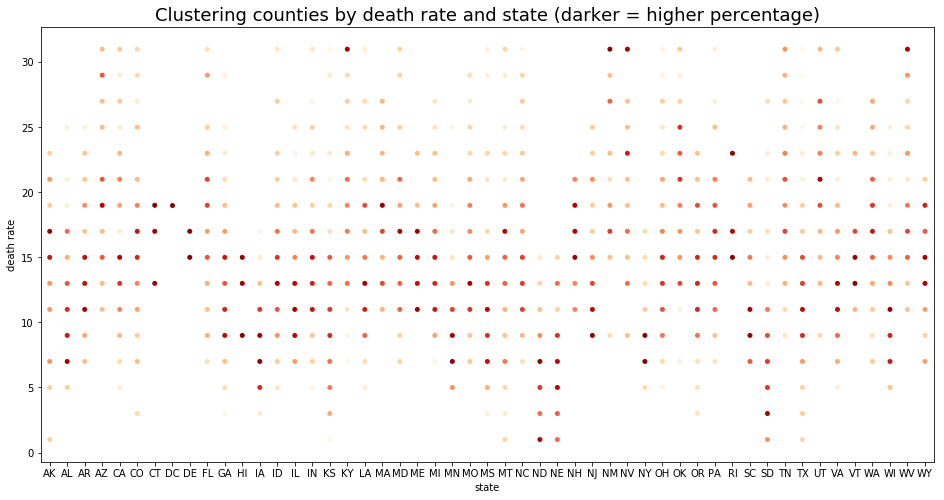

In [292]:
plt.rcParams["figure.figsize"] = [16.0, 8.0]
ax = sns.stripplot(data=counts, x='state', y='numeric', hue='percent', palette='OrRd')
ax.legend_.remove()
ax.set_title('Clustering counties by death rate and state (darker = higher percentage)', size=18)
ax.set_ylabel('death rate')

While there are some states with outlying concentrations of counties with low or high death rates, the distribution is fairly even overall.

In [293]:
data_31 = data.copy()
data = data[data['death_rate'] != '30+']

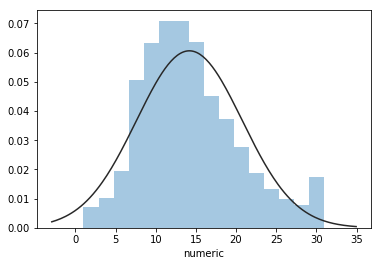

In [294]:
plt.rcParams["figure.figsize"] = [6.0, 4.0]
from scipy.stats import norm
sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)

The target distribution is not normal, but it follows the general shape of a normal curve except for the high-end spike at death_rate = 31. The class imbalance will have to be dealt with. 

In [295]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.590198  0.173795     0.014397      0.420872   
degree+         0.590198  1.000000  0.436721     0.037746      0.329834   
pop_inc         0.173795  0.436721  1.000000     0.001243      0.253635   
foreign_inc     0.014397  0.037746  0.001243     1.000000      0.003454   
unemployment    0.420872  0.329834  0.253635     0.003454      1.000000   
unemp_change    0.127994  0.117896  0.029990     0.003099      0.213587   
poverty         0.663283  0.447611  0.267106     0.014567      0.600237   
median_hh_inc   0.542180  0.680273  0.466601     0.018149      0.454140   
pov_change      0.043761  0.031475  0.047822     0.001281      0.202458   
median_age      0.221839  0.178017  0.364938     0.035829      0.061179   
hh_afr_am       0.363750  0.091370  0.102100     0.003461      0.422107   
hh_hisp         0.452917  0.020773  0.177056     0.001030      0.013150   
hh_female       0.546617 

**poverty** correlates strongly with a couple of other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [296]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

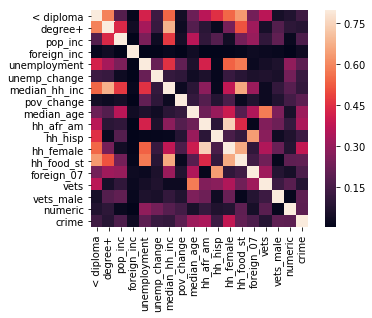

In [297]:
corrmat = data.drop(['state', 'name', 'urban_influence', 'pop_2014', 'death_rate'], axis=1).corr().abs()
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

There are still some strong correlations, but they are scattered. Use VIF analysis to programmatically eliminate the variables with the highest VIF scores until all scores are below 10, a conservative threshold.

In [298]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each column in features, calculate VIF and save in dataframe
vif = pd.DataFrame()
remove = ['state', 'name', 'urban_influence', 'pop_2014', 'death_rate', 'numeric']
features = data.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,23.727191,< diploma
1,19.038561,degree+
2,1.649532,pop_inc
3,1.022300,foreign_inc
4,16.496006,unemployment
5,4.113846,unemp_change
6,45.701203,median_hh_inc
7,1.217936,pov_change
8,151.793720,median_age
9,4.062589,hh_afr_am


In [299]:
max_VIF = max(vif['VIF'])
while max_VIF > 10:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = data.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,7.393791,degree+
1,1.338485,pop_inc
2,1.021619,foreign_inc
3,3.636447,unemp_change
4,1.172304,pov_change
5,2.085686,hh_afr_am
6,2.688671,hh_hisp
7,5.496295,hh_food_st
8,3.662824,foreign_07
9,9.296857,vets


In [300]:
features1 = list(vif['features']) + ['urban_influence', 'death_rate']

In [301]:
data1 = data.loc[:, features1]

In [302]:
data1.describe()

,degree+,pop_inc,foreign_inc,unemp_change,pov_change,hh_afr_am,hh_hisp,hh_food_st,foreign_07,vets,crime,urban_influence
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,20.936456,0.003378,0.404249,2.961078,-0.553704,0.082971,0.059307,0.102264,4.292097,0.088620,0.020376,5.205688
std,9.154237,0.041861,3.094303,1.783505,2.141838,0.139566,0.111013,0.056556,5.528622,0.022547,0.013327,3.469448
min,2.985000,-0.177510,-6.333333,-8.200000,-15.900000,0.000000,0.000000,0.000000,0.000000,0.019065,0.000000,1.000000
25%,14.571000,-0.021187,0.008944,1.800000,-1.700000,0.002650,0.009731,0.061792,1.200000,0.074239,0.011210,2.000000
50%,18.640500,-0.003907,0.059489,2.800000,-0.500000,0.013880,0.020117,0.092311,2.300000,0.087297,0.018461,5.000000
75%,24.783250,0.020743,0.204738,4.000000,0.600000,0.098243,0.052727,0.132885,5.100000,0.100467,0.027261,8.000000
max,80.210000,0.727044,119.000000,13.600000,17.400000,0.832707,0.955767,0.399738,63.100000,0.297533,0.157014,12.000000


All of the features besides the categorical **urban_influence** have strong outliers, as can be seen from the min and max values compared to the IQR.

In [303]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [304]:
predictors = data1.drop('death_rate', axis=1)

outliers = get_outliers(predictors)
len(data1[outliers.any(axis=1)])

1349

More than 1/3 of the records contain outliers, using the standard definition.

In [305]:
strong_outliers = get_outliers(predictors, 2.0)
len(data1[strong_outliers.any(axis=1)])

1052

In [306]:
extreme_outliers = get_outliers(predictors, 2.5)
len(data1[extreme_outliers.any(axis=1)])

845

In [307]:
len(data1[extreme_outliers.sum(axis=1) > 1])

217

Removing even just the extreme outliers would take away almost 1/3 of the data, but removing records with 2 or more extreme outliers will reduce the dataset by only 7.5%. Try this first

In [308]:
data1 = data1.drop(data1[extreme_outliers.sum(axis=1) > 1].index)

In [309]:
len(data1)

2807

Try a range of classifiers. 

In [310]:
X1 = data1.drop('death_rate', axis=1)
X1 = pd.get_dummies(X1, prefix='urb_inf_', columns=['urban_influence'])
Y1 = data1.loc[:, 'death_rate']

In [311]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()

from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [312]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [313]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=.35, random_state=13, stratify=Y1)

In [314]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(class_weight='balanced', tol=1e-3)
rfc = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

In [315]:
classifiers = [lrc, gbc, sgd, rfc, svc, knn]
names = ['Logistic regression', 'Gradient boosting', 'SGD', 'Random forest', 'Support vector', 'K-Nearest neighbors']

def run_trials(X, Y):
    for name, clf in zip(names, classifiers):
        %time cross_val_score(clf, robust.fit_transform(X), Y, scoring=matthews)
        scores = cross_val_score(clf, robust.fit_transform(X), Y, scoring=matthews)
        print('{} scores: {}'.format(name, scores))
        print('Average score: {}'.format(np.mean(scores)))

In [316]:
run_trials(X1_train, Y1_train)

CPU times: user 437 ms, sys: 8.27 ms, total: 445 ms
Wall time: 188 ms
Logistic regression scores: [ 0.03443237  0.05343197  0.05088997]
Average score: 0.046251435521370315
CPU times: user 8.7 s, sys: 27.4 ms, total: 8.73 s
Wall time: 8.64 s
Gradient boosting scores: [ 0.04695897  0.05201448  0.02691383]
Average score: 0.0419624278120417
CPU times: user 116 ms, sys: 1.93 ms, total: 118 ms
Wall time: 42.4 ms
SGD scores: [ 0.03809386  0.01917049  0.02013095]
Average score: 0.025798432590539776
CPU times: user 250 ms, sys: 5.88 ms, total: 256 ms
Wall time: 149 ms
Random forest scores: [ 0.0264427   0.03735823  0.04240895]
Average score: 0.03540329203255972
CPU times: user 522 ms, sys: 1.61 ms, total: 524 ms
Wall time: 524 ms
Support vector scores: [ 0.03941453  0.0659676   0.06859878]
Average score: 0.05799363513685964
CPU times: user 87.9 ms, sys: 540 µs, total: 88.4 ms
Wall time: 88.4 ms
K-Nearest neighbors scores: [ 0.0461835   0.04728616  0.03039442]
Average score: 0.041288027211141214

All of the stock classifiers performed poorly. Try an alternative selection process starting with correlations with the target variable.

In [317]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
bivariate.loc['numeric']

< diploma        0.071415
degree+          0.095094
pop_inc          0.022837
foreign_inc      0.002764
unemployment     0.289674
unemp_change     0.235700
median_hh_inc    0.180909
pov_change       0.142860
median_age       0.056238
hh_afr_am        0.116110
hh_hisp          0.067249
hh_female        0.077653
hh_food_st       0.194698
foreign_07       0.049836
vets             0.182828
vets_male        0.013722
numeric          1.000000
crime            0.191859
Name: numeric, dtype: float64

In [318]:
features2 = list(bivariate[bivariate.loc['numeric'] > .05].index)
features2.remove('numeric')

In [319]:
vif = pd.DataFrame()
features = data.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,18.400137,< diploma
1,15.395662,degree+
2,15.916503,unemployment
3,4.046981,unemp_change
4,34.719466,median_hh_inc
5,1.200618,pov_change
6,71.139734,median_age
7,3.671207,hh_afr_am
8,2.370453,hh_hisp
9,28.840613,hh_female


In [320]:
max_VIF = max(vif['VIF'])
while max_VIF > 10:
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = data.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,5.415383,degree+
1,3.569257,unemp_change
2,1.145696,pov_change
3,2.049218,hh_afr_am
4,1.447379,hh_hisp
5,5.283501,hh_food_st
6,8.603989,vets
7,4.206281,crime


(0, 0.2)

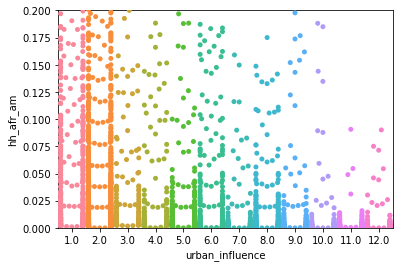

In [321]:
sns.swarmplot(y=data['hh_afr_am'], x=data['urban_influence'])
plt.ylim(0, .2)

(0, 0.2)

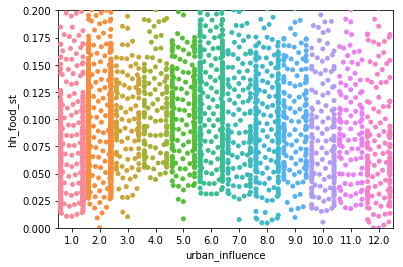

In [322]:
sns.swarmplot(y=data['hh_food_st'], x=data['urban_influence'])
plt.ylim(0,.2)

Patterns are apparent when lookiing at **urban_influence** vs. **hh_afr_am** and **hh_food_st** and could affect the results, especially with regard to **hh_afr_am**, but the relationships are complicated. There seems no reason to remove any of these features at this point.

In [323]:
features2 = list(vif['features'])
data2 = data.loc[:, features2]

In [324]:
outliers2 = get_outliers(data2)
len(data2[outliers2.any(axis=1)])

1074

In [325]:
strong_outliers2 = get_outliers(data2, 2.0)
len(data2[strong_outliers2.any(axis=1)])

767

In [326]:
extreme_outliers2 = get_outliers(data2, 2.5)
len(data2[extreme_outliers2.any(axis=1)])

579

In [327]:
len(data2[extreme_outliers2.sum(axis=1) > 1])

37

The number of samples with 2 or more extreme outliers is very small, so remove them.

In [328]:
#features2 = features2 + ['urban_influence', 'death_rate']
data2 = data.loc[:, features2 + ['urban_influence', 'death_rate']]
data2 = data2.drop(list(extreme_outliers2[extreme_outliers2.sum(axis=1) > 1].index))

In [329]:
len(data2)

2987

In [330]:
X2 = data2.drop('death_rate', axis=1)
X2 = pd.get_dummies(X2, prefix='urb_inf_', columns=['urban_influence'])
Y2 = data2.loc[:, 'death_rate']

In [331]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=.35, random_state=13, stratify=Y2)

In [332]:
run_trials(X2_train, Y2_train)

CPU times: user 402 ms, sys: 8.11 ms, total: 410 ms
Wall time: 154 ms
Logistic regression scores: [ 0.0653542   0.06426051  0.05446288]
Average score: 0.06135919647188473
CPU times: user 8.19 s, sys: 28.2 ms, total: 8.22 s
Wall time: 8.12 s
Gradient boosting scores: [ 0.00540842  0.03886064  0.03788478]
Average score: 0.027384609779881112
CPU times: user 171 ms, sys: 3.04 ms, total: 174 ms
Wall time: 62.9 ms
SGD scores: [ 0.02105541  0.03114713  0.01756427]
Average score: 0.023255602472167413
CPU times: user 246 ms, sys: 3.92 ms, total: 250 ms
Wall time: 140 ms
Random forest scores: [ 0.04999875  0.05875473  0.06559937]
Average score: 0.0581176181274245
CPU times: user 544 ms, sys: 1.01 ms, total: 545 ms
Wall time: 545 ms
Support vector scores: [ 0.09077613  0.07653431  0.06100204]
Average score: 0.07610416084229144
CPU times: user 74.5 ms, sys: 365 µs, total: 74.9 ms
Wall time: 74.7 ms
K-Nearest neighbors scores: [ 0.04922203  0.05342833  0.04492025]
Average score: 0.04919020524680038

The scores are significantly better for the best-performing algorithms (support vector and logistic regression), and only 37 outliers were dropped. Look at performance with all extreme outliers removed, since the total is only 2/3 the number with the first feature set.

In [333]:
data3 = data.loc[:, features2 + ['urban_influence', 'death_rate']]
data3 = data3.drop(list(extreme_outliers2[extreme_outliers2.any(axis=1)].index))

In [334]:
X3 = data3.drop('death_rate', axis=1)
X3 = pd.get_dummies(X3, prefix='urb_inf_', columns=['urban_influence'])
Y3 = data3.loc[:, 'death_rate']
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=.35, random_state=13, stratify=Y3)

In [335]:
run_trials(X3_train, Y3_train)

CPU times: user 352 ms, sys: 9.63 ms, total: 362 ms
Wall time: 126 ms
Logistic regression scores: [ 0.03824766  0.0527296   0.05058477]
Average score: 0.04718734470516132
CPU times: user 7.07 s, sys: 13.7 ms, total: 7.08 s
Wall time: 6.98 s
Gradient boosting scores: [ 0.04652708  0.03670271  0.04415721]
Average score: 0.042462333150347774
CPU times: user 182 ms, sys: 3.39 ms, total: 186 ms
Wall time: 63.9 ms
SGD scores: [ 0.04114135  0.04613672  0.0539563 ]
Average score: 0.04707812444209722
CPU times: user 226 ms, sys: 3.29 ms, total: 229 ms
Wall time: 119 ms
Random forest scores: [ 0.05084478  0.05185557  0.03654259]
Average score: 0.04641431527687714
CPU times: user 369 ms, sys: 1.09 ms, total: 370 ms
Wall time: 370 ms
Support vector scores: [ 0.05955823  0.04819215  0.06224929]
Average score: 0.05666656026190261
CPU times: user 67.2 ms, sys: 220 µs, total: 67.4 ms
Wall time: 67.4 ms
K-Nearest neighbors scores: [ 0.04391032  0.04042087  0.04513987]
Average score: 0.04315702109785544

With more outliers removed, performance is not as good. Use the second set minus the most extreme outliers, but combine to form fewer targets.  

In [336]:
Y2_16 = Y2.apply(lambda x: '0-1.9' if x == '<2' else x)

In [337]:
def combine_targets(input):
    targets = sorted(input.unique(), key=lambda x: int(re.search('\d+(?=-)', x).group()))
    first = []
    second = []
    for i, r in enumerate(targets):
        first.append(r) if i % 2 == 0 else second.append(r)
    if len(first) != len(second):
        second.append('30-31.9')
    conversions = {}
    for start, end in zip(first, second):
        new_value = re.search('\d+-', start).group() + re.search('(?<=-)\d+.\d+', end).group()
        conversions.update(dict.fromkeys([start, end], new_value))
    return input.apply(lambda x: conversions[x])

In [338]:
Y2_8 = combine_targets(Y2_16)

In [339]:
Y2_8_train = Y2_8[list(Y2_train.index)]
Y2_8_test = Y2_8[list(Y2_test.index)]

In [340]:
run_trials(X2_train, Y2_8_train)

CPU times: user 255 ms, sys: 6.12 ms, total: 261 ms
Wall time: 91.4 ms
Logistic regression scores: [ 0.13495088  0.16425267  0.1225845 ]
Average score: 0.14059601710547753
CPU times: user 4.3 s, sys: 8.58 ms, total: 4.31 s
Wall time: 4.2 s
Gradient boosting scores: [ 0.12309515  0.10005439  0.08209256]
Average score: 0.10174736717933698
CPU times: user 130 ms, sys: 2.76 ms, total: 133 ms
Wall time: 49 ms
SGD scores: [ 0.06832587  0.09870946  0.04928216]
Average score: 0.07210583047473013
CPU times: user 231 ms, sys: 3.68 ms, total: 235 ms
Wall time: 124 ms
Random forest scores: [ 0.08158314  0.13992633  0.07025503]
Average score: 0.09725483694188662
CPU times: user 457 ms, sys: 806 µs, total: 457 ms
Wall time: 457 ms
Support vector scores: [ 0.13318047  0.14307468  0.12523275]
Average score: 0.13382929923377543
CPU times: user 71.4 ms, sys: 303 µs, total: 71.7 ms
Wall time: 71.7 ms
K-Nearest neighbors scores: [ 0.0957713   0.06098616  0.06262617]
Average score: 0.07312787835971878


There was significant improvement, but performance is still poor. Try reducing to 4 classes.

In [341]:
Y2_4_train = combine_targets(Y2_8_train)
Y2_4_test = combine_targets(Y2_8_test)

In [342]:
run_trials(X2_train, Y2_4_train)

CPU times: user 150 ms, sys: 4.59 ms, total: 154 ms
Wall time: 53.3 ms
Logistic regression scores: [ 0.24084626  0.24144025  0.2268742 ]
Average score: 0.2363869043773474
CPU times: user 2.17 s, sys: 5.97 ms, total: 2.17 s
Wall time: 2.06 s
Gradient boosting scores: [ 0.23331993  0.26587384  0.17162678]
Average score: 0.2236068506207065
CPU times: user 91.7 ms, sys: 1.71 ms, total: 93.5 ms
Wall time: 32 ms
SGD scores: [ 0.192627    0.2716321   0.14548726]
Average score: 0.20324878665958368
CPU times: user 211 ms, sys: 3.49 ms, total: 214 ms
Wall time: 104 ms
Random forest scores: [ 0.20955079  0.25271245  0.13779571]
Average score: 0.20001964914878193
CPU times: user 382 ms, sys: 2.74 ms, total: 385 ms
Wall time: 385 ms
Support vector scores: [ 0.2400265   0.20753516  0.20853107]
Average score: 0.21869757767825235
CPU times: user 68.5 ms, sys: 228 µs, total: 68.8 ms
Wall time: 68.7 ms
K-Nearest neighbors scores: [ 0.18547823  0.21382778  0.19031909]
Average score: 0.19654169790769171


In [343]:
Y2_2_train = combine_targets(Y2_4_train)
Y2_2_test = combine_targets(Y2_4_test)

In [344]:
run_trials(X2_train, Y2_2_train)

CPU times: user 33.9 ms, sys: 1.73 ms, total: 35.7 ms
Wall time: 34.4 ms
Logistic regression scores: [ 0.36626722  0.42487928  0.38697557]
Average score: 0.3927073577578684
CPU times: user 489 ms, sys: 1.13 ms, total: 490 ms
Wall time: 490 ms
Gradient boosting scores: [ 0.29586078  0.40709062  0.28666356]
Average score: 0.3298716522272344
CPU times: user 24.2 ms, sys: 157 µs, total: 24.4 ms
Wall time: 24.3 ms
SGD scores: [ 0.21702885  0.29825045  0.27594182]
Average score: 0.2637403756277514
CPU times: user 95 ms, sys: 252 µs, total: 95.3 ms
Wall time: 95.4 ms
Random forest scores: [ 0.26739801  0.31078799  0.27503446]
Average score: 0.2844068196142913
CPU times: user 232 ms, sys: 1.55 ms, total: 234 ms
Wall time: 234 ms
Support vector scores: [ 0.33687477  0.43596485  0.4040663 ]
Average score: 0.39230197448291687
CPU times: user 69.1 ms, sys: 188 µs, total: 69.3 ms
Wall time: 69.3 ms
K-Nearest neighbors scores: [ 0.28190545  0.36722807  0.22763312]
Average score: 0.2922555465753007


In [345]:
svc.fit(robust.fit_transform(X2_train), Y2_2_train)
matthews_corrcoef(Y2_2_test, svc.predict(robust.fit_transform(X2_test)))

0.41847912457764941

In [346]:
lrc.fit(robust.fit_transform(X2_train), Y2_2_train)
matthews_corrcoef(Y2_2_test, lrc.predict(robust.fit_transform(X2_test)))

0.37060868281691173

Support vector performs better on the test set, but logistic regression is more interpretable, so optimize both. A quick check of results with and without the **30+** target values showed that the model performs better with them included, so leave them in.

In [347]:
binary = data_31.copy()
binary['crime'] = (binary['viol_crime'] + binary['prop_crime'])
binary = binary.drop(['viol_crime', 'prop_crime', 'urban_influence'], axis=1)
binary = binary.loc[:, features2]

extreme_outliers3 = get_outliers(binary, 2.5)

binary['urban_influence'] = data_31['urban_influence']
binary['high_death_rate'] = np.where(data_31['numeric'] > 15, 1, 0)

binary = binary.drop(list(extreme_outliers3[extreme_outliers3.sum(axis=1) > 1].index))


In [348]:
X = binary.drop('high_death_rate', axis=1)
X = pd.get_dummies(X, prefix='urb_inf_', columns=['urban_influence'])
Y = binary.loc[:, 'high_death_rate']

In [349]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [350]:
def optimize(clf, params, X, Y, t_size, rand):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=t_size, random_state=rand, stratify=Y)
    model = GridSearchCV(clf, param_grid=params, scoring=matthews)
    model.fit(robust.fit_transform(X_train), Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    Xr_test = robust.fit_transform(X_test)
    preds = model.predict(Xr_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(model.best_estimator_.decision_function(Xr_test))
    plt.scatter(residuals.index, residuals)
    return model

In [351]:
lrc_params = [{ 'penalty': ['l1', 'l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5],
               'solver': ['liblinear'], 'multi_class': ['ovr']},
            { 'penalty': ['l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5],
             'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}]

# The sag and saga solvers did not converge, and neither did the other solvers for tolerance values below .0001

Optimal parameters: {'C': 4, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}
Matthews score: 0.3480482448667789
ROC-AUC score: 0.683252427184466
[[281 131]
 [ 65 141]]


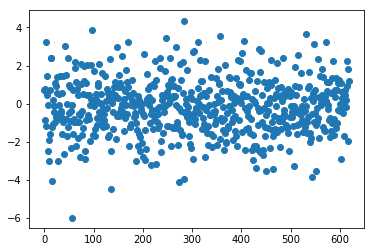

In [352]:
lrc_1 = optimize(lrc, lrc_params, X, Y, 0.2, 13)

Optimal parameters: {'C': 5, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.3708142160452492
ROC-AUC score: 0.6953883495145631
[[283 129]
 [ 61 145]]


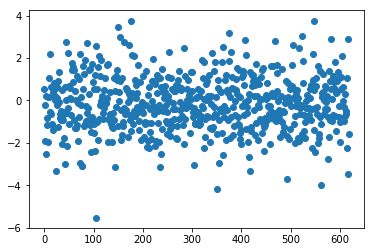

In [353]:
lrc_2 = optimize(lrc, lrc_params, X, Y, 0.2, 37)

A different data split results in different optimal values for C and the penalty, as well as significantl differences in the scores, indicating potential instabillity. But the confusion matrices show the models consistently performing fairly well on classifying the high death rates and very poorly on the low death rates. In both cases the residuals are evenly distributed around 0.  

In [354]:
svc_params = {'C': [0.5, 1, 4, 7], 'kernel': ['linear', 'poly', 'rbf'],
             'gamma': [0.1, 0.12, 0.14], 'tol': [1e-7, 5e-7, 1e-6, 5e-6]}

Optimal parameters: {'C': 1, 'gamma': 0.14, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.43405167074723355
ROC-AUC score: 0.7281553398058253
[[296 116]
 [ 54 152]]


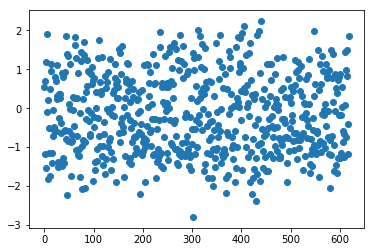

In [355]:
svc_1 = optimize(svc, svc_params, X, Y, .2, 13)

Optimal parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.43405167074723355
ROC-AUC score: 0.7281553398058253
[[296 116]
 [ 54 152]]


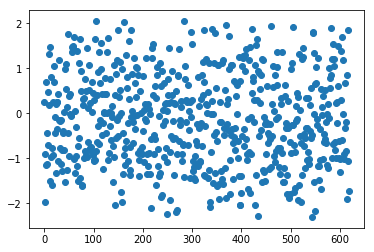

In [356]:
svc_2 = optimize(svc, svc_params, X, Y, .2, 37)

The support vector model is extremely stable, with exactly the same performance and the same optimal parameter selection, with the minor exception of slightly different values for the gamma parameter. (The residuals plots also show differences.) As with the logistic regression, the residuals plot does not show heteroscedasticity, and the values are concentrated in a narrower band around 0.

Optimal parameters: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.31603366505385294
ROC-AUC score: 0.6674757281553397
[[260 152]
 [ 61 145]]


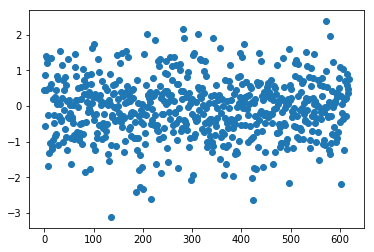

In [357]:
X_mod = X.drop('hh_afr_am', axis=1)
lrc_3 = optimize(lrc, lrc_params, X_mod, Y, 0.2, 13)

Optimal parameters: {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.2918237357523379
ROC-AUC score: 0.654126213592233
[[267 145]
 [ 70 136]]


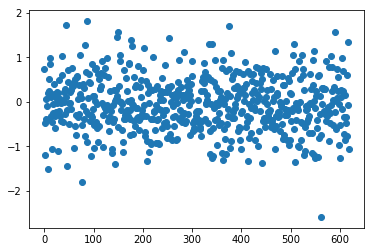

In [358]:
lrc_4 = optimize(lrc, lrc_params, X_mod, Y, 0.2, 37)

The model is neither more accurate nor more stable with **hh_afr_am** removed to reduce possible interdependence between **urb_inf_1.0** and **urb_inf_2.0**.

Shifting the high/low threshold for the death rate could help to balance the classes.

In [375]:
Y_bal = np.where(data_31.drop(extreme_outliers3[extreme_outliers3.sum(axis=1) > 1].index)['numeric'] < 15, 0, 1)
print(len(Y_bal[Y_bal == 0]), len(Y_bal[Y_bal == 1]))

1688 1402


This is the most balanced split possible.

Optimal parameters: {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001}
Matthews score: 0.38946920889796594
ROC-AUC score: 0.6955938292476754
[[230 108]
 [ 81 199]]


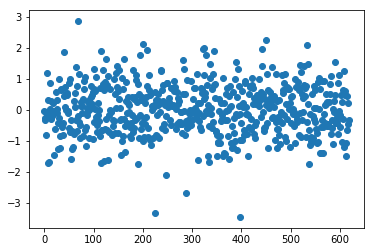

In [376]:
lrc_5 = optimize(lrc, lrc_params, X, Y_bal, 0.2, 13)

Optimal parameters: {'C': 5, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.3770688213404151
ROC-AUC score: 0.689370245139476
[[227 111]
 [ 82 198]]


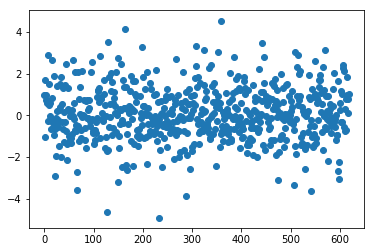

In [377]:
lrc_6 = optimize(lrc, lrc_params, X, Y_bal, 0.2, 37)

Optimal parameters: {'C': 1, 'gamma': 0.12, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.4598405125716997
ROC-AUC score: 0.7308960270498732
[[243  95]
 [ 72 208]]


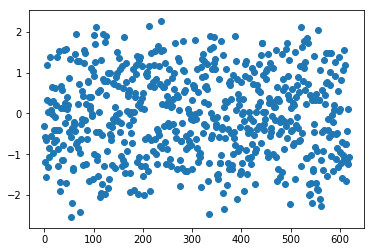

In [378]:
svc_3 = optimize(svc, svc_params, X, Y_bal, .2, 13)

Optimal parameters: {'C': 4, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.45927051494714977
ROC-AUC score: 0.7306424344885883
[[238 100]
 [ 68 212]]


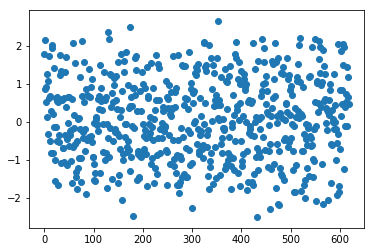

In [379]:
svc_4 = optimize(svc, svc_params, X, Y_bal, .2, 37)

Changing the death rate split from almost 2:1 to approximately 7:6 improved the results only slightly, indicating that the problem lies not with the class balance but with the predictive power of the data itself. With the more balanced split, however, the errors were more evenly distributed among false positives and false negatives, and the difference in the optimal gamma parameters for the two runs went from .1/.14 to .1/.12, so support vector with the more balanced split is the best model.

Changing the death rate split from almost 2:1 to approximately 7:6 improved the results only slightly, indicating that the problem lies not with the class balance but with the predictive power of the data itself. With the more balanced split, hoever, the errors were more evenly distributed among false positives and false negatives, so support vector with the more balanced split is the best model.

In [380]:
feature_rank = zip(X.columns, lrc_5.best_estimator_.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))

hh_food_st   :  0.61705  OR: 1.85 
crime        :  0.44606  OR: 1.56 
vets         :  0.32455  OR: 1.38 
unemp_change :  0.30987  OR: 1.36 
urb_inf__1.0 :  0.22706  OR: 1.25 
urb_inf__11. :  0.08139  OR: 1.08 
urb_inf__7.0 :  0.05774  OR: 1.06 
urb_inf__2.0 :  0.03110  OR: 1.03 
urb_inf__10. :  0.03007  OR: 1.03 
urb_inf__4.0 :  0.02559  OR: 1.03 
urb_inf__3.0 : -0.00272  OR: 1.00 
hh_hisp      : -0.04780  OR: 0.95 
urb_inf__6.0 : -0.05334  OR: 0.95 
degree+      : -0.05853  OR: 0.94 
urb_inf__12. : -0.06332  OR: 0.94 
urb_inf__9.0 : -0.06601  OR: 0.94 
urb_inf__8.0 : -0.09436  OR: 0.91 
urb_inf__5.0 : -0.17320  OR: 0.84 
pov_change   : -0.17931  OR: 0.84 
hh_afr_am    : -0.38441  OR: 0.68 


In [381]:
feature_rank = zip(X.columns, lrc_6.best_estimator_.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))

hh_food_st   :  1.25983  OR: 3.52 
crime        :  0.69065  OR: 2.00 
urb_inf__1.0 :  0.68799  OR: 1.99 
vets         :  0.58396  OR: 1.79 
urb_inf__11. :  0.54115  OR: 1.72 
unemp_change :  0.53096  OR: 1.70 
urb_inf__7.0 :  0.25116  OR: 1.29 
urb_inf__10. :  0.24683  OR: 1.28 
urb_inf__4.0 :  0.21182  OR: 1.24 
degree+      :  0.12844  OR: 1.14 
urb_inf__2.0 :  0.02227  OR: 1.02 
urb_inf__9.0 :  0.00000  OR: 1.00 
hh_hisp      : -0.06308  OR: 0.94 
urb_inf__8.0 : -0.12519  OR: 0.88 
urb_inf__3.0 : -0.14829  OR: 0.86 
pov_change   : -0.24739  OR: 0.78 
urb_inf__6.0 : -0.27575  OR: 0.76 
urb_inf__12. : -0.35247  OR: 0.70 
hh_afr_am    : -0.59582  OR: 0.55 
urb_inf__5.0 : -0.84009  OR: 0.43 


Aside from a few juxtaposed neighbors, the features are in the same order. Certainly the opposition of urban influence category 1 with higher percentages of African American households is something worth investigating given the seeming high correlation between these two. 

In [388]:
full = data_31.copy()
full['crime'] = (full['viol_crime'] + full['prop_crime'])
full = full.drop(['state', 'name', 'urban_influence', 'pop_2014', 'viol_crime', 'prop_crime',
                  'death_rate', 'numeric'], axis=1)

extreme_outliers4 = get_outliers(full, 2.5)



In [389]:
len(extreme_outliers4[extreme_outliers4.sum(axis=1) > 1])

278

In [390]:
full['urban_influence'] = data_31['urban_influence']
full['high_death_rate'] = np.where(data_31['numeric'] < 15, 0, 1)

#full = full.drop(list(extreme_outliers4[extreme_outliers4.sum(axis=1) > 1].index))

In [391]:
X_full = full.drop('high_death_rate', axis=1)
X_full = pd.get_dummies(X_full, prefix='urb_inf_', columns=['urban_influence'])
Y_full = full.loc[:, 'high_death_rate']

Optimal parameters: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Matthews score: 0.4561386121555704
ROC-AUC score: 0.7290072010631612
[[248  95]
 [ 75 208]]


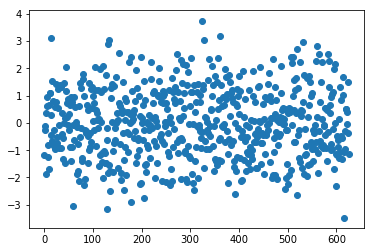

In [392]:
lrc_full_1 = optimize(lrc, lrc_params, X_full, Y_full, 0.2, 13)

Optimal parameters: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.49878400070141715
ROC-AUC score: 0.7500334813380173
[[260  83]
 [ 73 210]]


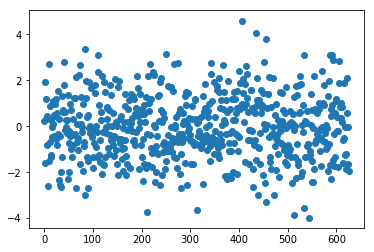

In [393]:
lrc_full_2 = optimize(lrc, lrc_params, X_full, Y_full, 0.2, 37)

In [394]:
def run_clf(estimator, X, Y, rand):
    clf = estimator
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=rand, stratify=Y)
    clf.fit(robust.fit_transform(X_train), Y_train)
    Xr_test = robust.fit_transform(X_test)
    preds = clf.predict(Xr_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(clf.decision_function(Xr_test))
    plt.scatter(residuals.index, residuals)
    return clf

Matthews score: 0.47649392127405077
ROC-AUC score: 0.7375784235955867
[[266  77]
 [ 85 198]]


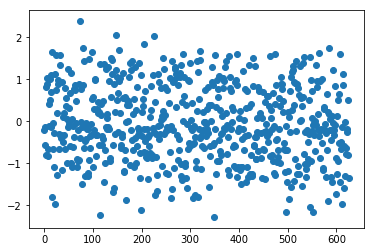

In [395]:
svc_full = SVC(class_weight='balanced', C=1, gamma=0.14, kernel='rbf', tol=1e-07)
svc_full_1 = run_clf(svc_full, X_full, Y_full, 13)

Matthews score: 0.4671932600317553
ROC-AUC score: 0.733205245753021
[[263  80]
 [ 85 198]]


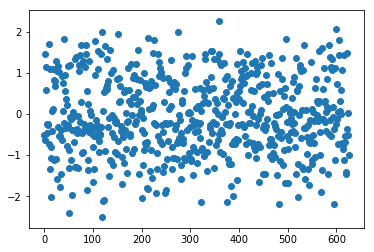

In [396]:
svc_full = SVC(class_weight='balanced', C=1, gamma=0.1, kernel='rbf', tol=1e-07)
svc_full_2 = run_clf(svc_full, X_full, Y_full, 37)

Using all the features with all the data produced higher test scores, and with the best-performing support vector model, excellent stability. The confusion matrices are identical except for +/- 3 true/false positives. In this case, feature selection and outlier removal did not improve performance.

Matthews score: 0.4113538445583689
ROC-AUC score: 0.706561707523246
[[235 103]
 [ 79 201]]


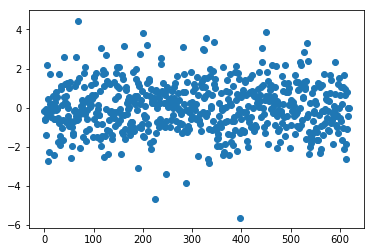

In [397]:
svc_linear = SVC(class_weight='balanced', C=1, gamma=0.12, kernel='linear', tol=1e-07)
svc_linear_1 = run_clf(svc_linear, X, Y_bal, 13)

In [398]:
feature_rank = zip(X.columns, svc_linear_1.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}'.format(f, r))

hh_food_st   :  1.13469
urb_inf__1.0 :  0.71128
crime        :  0.69382
urb_inf__11. :  0.56665
vets         :  0.51204
unemp_change :  0.44724
urb_inf__10. :  0.24986
urb_inf__7.0 :  0.23314
urb_inf__4.0 :  0.16334
urb_inf__2.0 :  0.03238
degree+      :  0.02831
hh_hisp      : -0.05465
urb_inf__12. : -0.08002
urb_inf__3.0 : -0.15393
urb_inf__6.0 : -0.17651
pov_change   : -0.24835
urb_inf__9.0 : -0.34058
urb_inf__8.0 : -0.44033
hh_afr_am    : -0.56338
urb_inf__5.0 : -0.76529


Matthews score: 0.43210953502196336
ROC-AUC score: 0.7170363349782113
[[241 102]
 [ 76 207]]


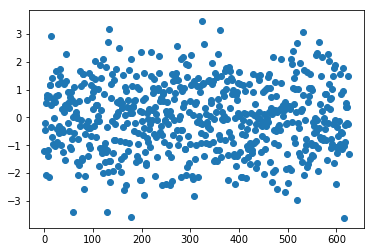

In [399]:
svc_linear_2 = run_clf(svc_linear, X_full, Y_full, 13)

In [401]:
feature_rank = zip(X_full.columns, svc_linear_2.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}'.format(f, r))

urb_inf__1.0 :  1.03096
hh_female    :  0.58014
< diploma    :  0.55809
crime        :  0.53868
degree+      :  0.51565
urb_inf__11. :  0.48324
unemployment :  0.46336
urb_inf__4.0 :  0.37969
median_age   :  0.31393
vets         :  0.31344
unemp_change :  0.29779
poverty      :  0.28665
urb_inf__2.0 :  0.14430
pop_inc      :  0.07210
urb_inf__10. :  0.05190
urb_inf__7.0 :  0.02672
urb_inf__3.0 :  0.02547
foreign_inc  : -0.00032
vets_male    : -0.01026
hh_food_st   : -0.02253
pov_change   : -0.05662
foreign_07   : -0.07704
hh_hisp      : -0.13707
urb_inf__8.0 : -0.15922
urb_inf__6.0 : -0.17173
urb_inf__9.0 : -0.39652
median_hh_in : -0.55319
urb_inf__12. : -0.60847
urb_inf__5.0 : -0.80634
hh_afr_am    : -0.84758


The linear kernel does not give optimal performance, but it does provide feature coefficients. The ranking of the reduced feature set is almost identical to that obtained from the optimized logistic regression model. The better performance of themodel on the full dataset gives credibility to the full feature ranking obtained from it, in which the order of the reduced features relative to one another stays more or less the same, but excluded features now appear between them.